# Load datasets 

# Stock trend classifiaction_train Inception Time

In [1]:
import numpy as np
import pandas as pd

CLASSES = [ "Bull" , "Bear"  ]  
LABEL_BULL = CLASSES.index( "Bull" )
LABEL_BEAR = CLASSES.index( "Bear" )

datasets = np.load("datasets.npz")
x_train, y_train = datasets["x_train"],datasets["y_train"]
x_val,y_val = datasets["x_val"],datasets["y_val"]
x_test,y_test = datasets["x_test"],datasets["y_test"]
                                             
# Label distribution 
label_distribution = pd.DataFrame([{"Dataset" : "train",
                                                         "Bull":np.count_nonzero(y_train == LABEL_BULL),
                                                         "Bear": np.count_nonzero(y_train == LABEL_BEAR)},
                                                         {"Dataset" : "val",
                                                         "Bull":np.count_nonzero(y_val == LABEL_BULL),
                                                         "Bear": np.count_nonzero(y_val == LABEL_BEAR)},
                                                         {"Dataset" : "test",
                                                         "Bull":np.count_nonzero(y_test == LABEL_BULL),
                                                         "Bear": np.count_nonzero(y_test == LABEL_BEAR)}])
label_distribution

,Dataset,Bull,Bear
0,train,888,803
1,val,263,220
2,test,120,120


# Construct model

In [2]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, \
                                                        BatchNormalization, Activation, \
                                                        Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model 

def inception_module(input_tensor):
    bottleneck = Conv1D(filters=32, kernel_size=1, padding="same", activation=None,
                       use_bias=False) (input_tensor)
    conv3 = Conv1D(filters=32, kernel_size=3, padding="same", activation=None,
                       use_bias=False) (bottleneck)
    conv5 = Conv1D(filters=32, kernel_size=5, padding="same", activation=None,
                       use_bias=False) (bottleneck)
    conv7 = Conv1D(filters=32, kernel_size=7, padding="same", activation=None,
                       use_bias=False) (bottleneck)
    mp = MaxPooling1D(pool_size=3, strides=1,padding="same")(input_tensor)
    mpbottleneck = Conv1D(filters=32, kernel_size=1, padding="same",activation=None,
                         use_bias=False)(mp)
    
    x = Concatenate(axis=-1)([conv3,conv5,conv7, mpbottleneck])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def shortcut_layer(input_tensor1, input_tensor2):
    shortcut = Conv1D(filters=input_tensor2.shape[-1], kernel_size=1, padding="same", activation=None, use_bias=False)(input_tensor1)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([shortcut, input_tensor2])
    x = Activation("relu")(x)
    return x

#Build model
n_time_steps = x_train.shape[1]
n_features = x_train.shape[2]

input_layer = Input(shape=(n_time_steps, n_features))
x = input_layer
input_residual = input_layer

for i in range(6):
    x = inception_module(x)
    
    if i % 3 == 2 :
        x = shortcut_layer(input_residual, x)
        input_residual = x

x = GlobalAveragePooling1D()(x)
output_layer = Dense(len(CLASSES), activation="softmax" )(x)

model = Model(inputs = input_layer, outputs= output_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 7)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 100, 32)      224         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 100, 7)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 100, 32)      3072        ['conv1d[0][0]']                 
                                                                                              

 max_pooling1d_3 (MaxPooling1D)  (None, 100, 128)    0           ['activation_3[0][0]']           
                                                                                                  
 conv1d_17 (Conv1D)             (None, 100, 32)      3072        ['conv1d_16[0][0]']              
                                                                                                  
 conv1d_18 (Conv1D)             (None, 100, 32)      5120        ['conv1d_16[0][0]']              
                                                                                                  
 conv1d_19 (Conv1D)             (None, 100, 32)      7168        ['conv1d_16[0][0]']              
                                                                                                  
 conv1d_20 (Conv1D)             (None, 100, 32)      4096        ['max_pooling1d_3[0][0]']        
                                                                                                  
 concatena

#  Train model

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model_checkpoint = ModelCheckpoint(filepath="best_model.hdf5", monitor ="val_loss",
                                  save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss", patience= 100, restore_best_weights=True)
callbacks = [model_checkpoint, early_stopping]

train_history = model.fit(x_train, to_categorical(y_train),
                         validation_data=(x_val, to_categorical(y_val)),
                         batch_size= 2048, epochs=1000, callbacks=[callbacks])


NameError: name 'model' is not defined

NameError: name 'train_history' is not defined

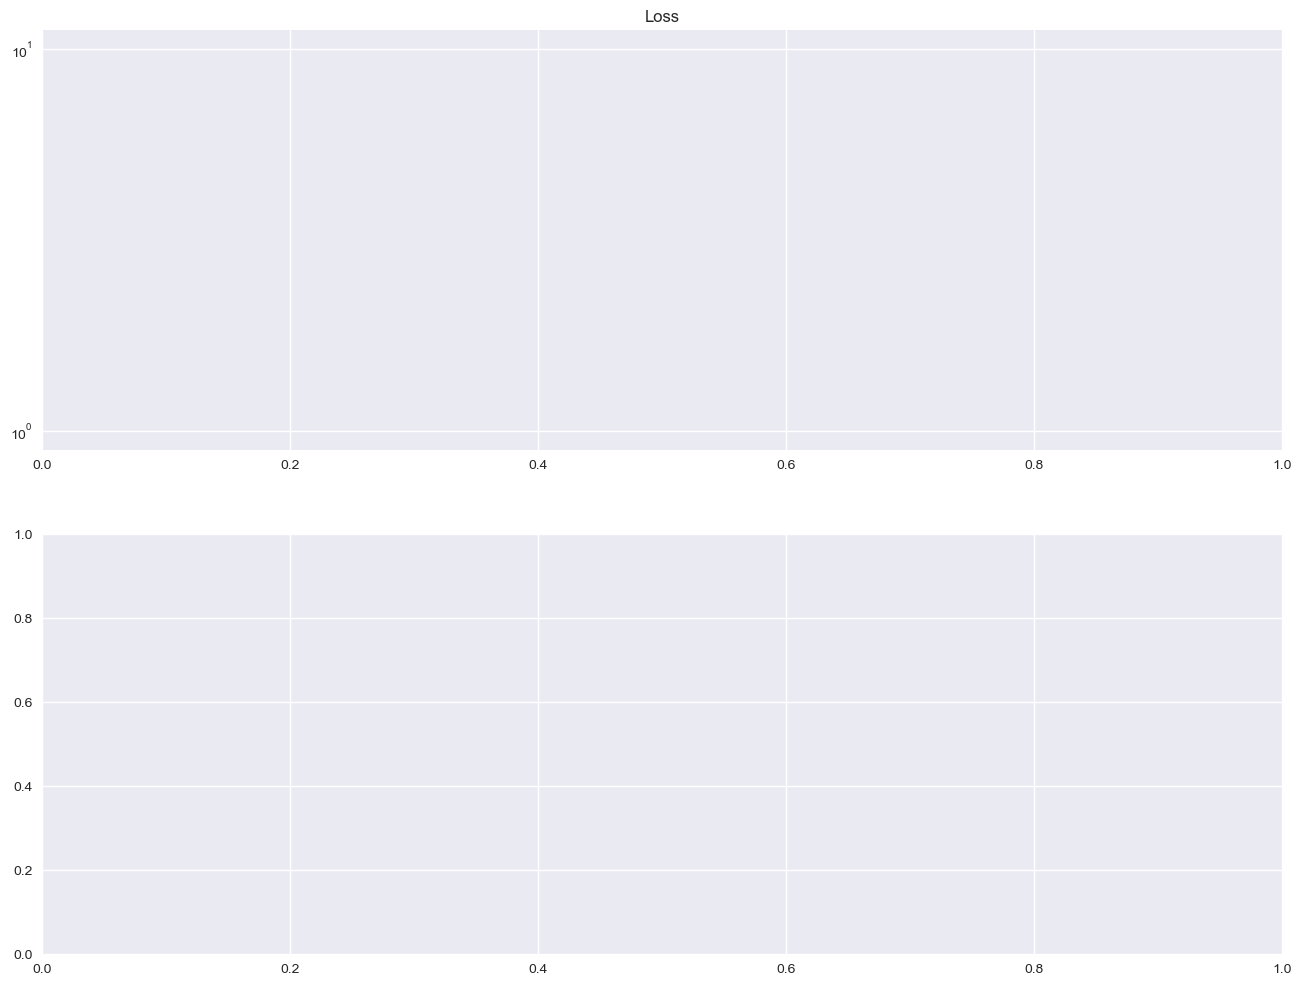

In [1]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(2,1,figsize=(16,12))

axes[0].set_title("Loss")
axes[0].set_yscale("log")
axes[0].plot(train_history.history["loss"], label="Training")
axes[0].plot(train_history.history["val_loss"], label= "Validation")
axes[0].legend()

axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].plot(train_history.history["accuracy"], label="Training")
axes[1].plot(train_history.history["val_accuracy"], label= "Validation")
axes[1].legend()
                  


In [ ]:
#股市分析員都喜歡從陰陽燭圖找圖案　所以模型擅長分析ＩＭＡＧＥ
#時間連續性　ＴＩＭＥ　ＳＥＲＩＥＳ
#股市預測數值不用　只需要預測漲跌　進行分裂ＣＬＡＳＳＩＦＩＣＡＴＩＯＮ
#ＩＮＣＥＰＴＩＯＮ　ＡＬＥＸＮＥＴ都是有關圖像ＡＩ的字眼
#裡面的ＣＯＮＶＯＬＵＴＩＯＮ可以用來分析陰陽燭圖

In [ ]:
#